<a href="https://colab.research.google.com/github/rahiakela/bert-research-series/blob/master/ep_2_bert_word_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Word Embeddings

In this post, I take an in-depth look at word embeddings produced by Google's BERT and show you how to get started with BERT by producing your own word embeddings.

This post is presented in two forms--as a blog post [here](http://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/) and as a Colab notebook [here](https://colab.research.google.com/drive/1yFphU6PW9Uo6lmDly_ud9a6c4RCYlwdX). 
The content is identical in both, but: 

* The blog post format may be easier to read, and includes a comments section for discussion. 
* The Colab Notebook will allow you to run the code and inspect it as you read through.

*Update 5/27/20 - I've updated this post to use the new `transformers` library  from huggingface in place of the old `pytorch-pretrained-bert` library. You can still find the old post / Notebook [here](https://colab.research.google.com/drive/1ZQvuAVwA3IjybezQOXnrXMGAnMyZRuPU) if you need it.* 

Reference:

http://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/

https://www.youtube.com/watch?v=zJW57aCBCTk

## Introduction


### History

2018 was a breakthrough year in NLP. Transfer learning, particularly models like Allen AI's ELMO, OpenAI's Open-GPT, and Google's BERT allowed researchers to smash multiple benchmarks with minimal task-specific fine-tuning and provided the rest of the NLP community with pretrained models that could easily (with less data and less compute time) be fine-tuned and implemented to produce state of the art results. Unfortunately, for many starting out in NLP and even for some experienced practicioners, the theory and practical application of these powerful models is still not well understood.

### What is BERT?

BERT (Bidirectional Encoder Representations from Transformers), released in late 2018, is the model we will use in this tutorial to provide readers with a better understanding of and practical guidance for using transfer learning models in NLP. BERT is a method of pretraining language representations that was used to create models that NLP practicioners can then download and use for free. You can either use these models to extract high quality language features from your text data, or you can fine-tune these models on a specific task (classification, entity recognition, question answering, etc.) with your own data to produce state of the art predictions.

### Why BERT embeddings?

In this tutorial, we will use BERT to extract features, namely word and sentence embedding vectors, from text data. What can we do with these word and sentence embedding vectors? First, these embeddings are useful for keyword/search expansion, semantic search and information retrieval. For example, if you want to match customer questions or searches against already answered questions or well documented searches, these representations will help you accuratley retrieve results matching the customer's intent and contextual meaning, even if there's no keyword  or phrase overlap.

Second, and perhaps more importantly, these vectors are used as high-quality feature inputs to downstream models. NLP models such as LSTMs or CNNs require inputs in the form of numerical vectors, and this typically means translating features like the vocabulary and parts of speech into numerical representations. In the past, words have been represented either as uniquely indexed values (one-hot encoding), or more helpfully as neural word embeddings where vocabulary words are matched against the fixed-length feature embeddings that result from models like Word2Vec or Fasttext. BERT offers an advantage over models like Word2Vec, because while each word has a fixed representation under Word2Vec regardless of the context within which the word appears, BERT produces word representations that are dynamically informed by the words around them. For example, given two sentences:

"The man was accused of robbing a bank."
"The man went fishing by the bank of the river."

Word2Vec would produce the same word embedding for the word "bank" in both sentences, while under BERT the word embedding for "bank" would be different for each sentence. Aside from capturing obvious differences like polysemy, the context-informed word embeddings capture other forms of information that result in more accurate feature representations, which in turn results in better model performance.

From an educational standpoint, a close examination of BERT word embeddings is a good way to get  your feet wet with BERT and its family of transfer learning models, and sets us up with some practical knowledge and context to better understand the inner details of the model in later tutorials.

Onward!

## 1- Loading Pre-Trained BERT

Install the pytorch interface for BERT by Hugging Face. (This library contains interfaces for other pretrained language models like OpenAI's GPT and GPT-2.) 

We've selected the pytorch interface because it strikes a nice balance between the high-level APIs (which are easy to use but don't provide insight into how things work) and tensorflow code (which contains lots of details but often sidetracks us into lessons about tensorflow, when the purpose here is BERT!).

If you're running this code on Google Colab, you will have to install this library each time you reconnect; the following cell will take care of that for you.

In [1]:
! pip install transformers

     |████████████████████████████████| 778kB 3.2MB/s 
     |████████████████████████████████| 3.0MB 7.3MB/s 
     |████████████████████████████████| 890kB 30.4MB/s 
     |████████████████████████████████| 1.1MB 33.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=dfe773534acc98e6af5f9b027643665ef9025349843667e837d5c5344ebf09ab
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


Now let's import pytorch, the pretrained BERT model, and a BERT tokenizer. 

We'll explain the BERT model in detail in a later tutorial, but this is the pre-trained model released by Google that ran for many, many hours on Wikipedia and [Book Corpus](https://arxiv.org/pdf/1506.06724.pdf), a dataset containing +10,000 books of different genres. This model is responsible (with a little modification) for beating NLP benchmarks across a range of tasks. Google released a few variations of BERT models, but the one we'll use here is the smaller of the two available sizes ("base" and "large") and ignores casing, hence "uncased.""

`transformers` provides a number of classes for applying BERT to different tasks (token classification, text classification, ...). Here, we're using the basic `BertModel` which has no specific output task--it's a good choice for using BERT just to extract embeddings.

In [2]:
import torch
from transformers import BertTokenizer, BertModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
# logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
% matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

## 2- Input Formatting

Because BERT is a pretrained model that expects input data in a specific format, we will need:

1. A **special token, `[SEP]`,** to mark the end of a sentence, or the separation between two sentences
2. A **special token, `[CLS]`,** at the beginning of our text. This token is used for classification tasks, but BERT expects it no matter what your application is. 
3. Tokens that conform with the fixed vocabulary used in BERT
4. The **Token IDs** for the tokens, from BERT's tokenizer
5. **Mask IDs** to indicate which elements in the sequence are tokens and which are padding elements
6. **Segment IDs** used to distinguish different sentences
7. **Positional Embeddings** used to show token position within the sequence

Luckily, the `transformers` interface takes care of all of the above requirements (using the `tokenizer.encode_plus` function). 

Since this is intended as an introduction to working with BERT, though, we're going to perform these steps in a (mostly) manual way. 

> *For an example of using `tokenizer.encode_plus`, see the next post on Sentence Classification [here](http://mccormickml.com/2019/07/22/BERT-fine-tuning/).*

### 2.1 Special Tokens 

BERT can take as input either one or two sentences, and uses the special token `[SEP]` to differentiate them. The `[CLS]` token always appears at the start of the text, and is specific to classification tasks. 

Both tokens are *always required*, however, even if we only have one sentence, and even if we are not using BERT for classification. That's how BERT was pre-trained, and so that's what BERT expects to see.

**2 Sentence Input**:

`[CLS] The man went to the store. [SEP] He bought a gallon of milk.`

**1 Sentence Input**:

`[CLS] The man went to the store. [SEP]`


### 2.2 Tokenization

BERT provides its own tokenizer, which we imported above. Let's see how it handles the below sentence.

In [3]:
text = "Here is the sentence I want embeddings for."
marked_text = "[CLS]" + text + "[SEP]"

# Tokenize our sentence with the BERT tokenizer.
tokenized_text = tokenizer.tokenize(marked_text)
print(tokenized_text)

['[CLS]', 'here', 'is', 'the', 'sentence', 'i', 'want', 'em', '##bed', '##ding', '##s', 'for', '.', '[SEP]']


Notice how the word "embeddings" is represented:

`['em', '##bed', '##ding', '##s']`

The original word has been split into smaller subwords and characters. The two hash signs preceding some of these subwords are just our tokenizer's way to denote that this subword or character is part of a larger word and preceded by another subword. So, for example, the '##bed' token is separate from the 'bed' token; the first is used whenever the subword 'bed' occurs within a larger word and the second is used explicitly for when the standalone token 'thing you sleep on' occurs.

Why does it look this way? This is because the BERT tokenizer was created with a WordPiece model. This model greedily creates a fixed-size vocabulary of individual characters, subwords, and words that best fits our language data. Since the vocabulary limit size of our BERT tokenizer model is 30,000, the WordPiece model generated a vocabulary that contains all English characters plus the ~30,000 most common words and subwords found in the English language corpus the model is trained on. This vocabulary contains four things:

1. Whole words
2. Subwords occuring at the front of a word or in isolation ("em" as in "embeddings" is assigned the same vector as the standalone sequence of characters "em" as in "go get em" )
3. Subwords not at the front of a word, which are preceded by '##' to denote this case
4. Individual characters

To tokenize a word under this model, the tokenizer first checks if the whole word is in the vocabulary. If not, it tries to break the word into the largest possible subwords contained in the vocabulary, and as a last resort will decompose the word into individual characters. Note that because of this, we can always represent a word as, at the very least, the collection of its individual characters.

As a result, rather than assigning out of vocabulary words to a catch-all token like 'OOV' or 'UNK,' words that are not in the vocabulary are decomposed into subword and character tokens that we can then generate embeddings for. 

So, rather than assigning "embeddings" and every other out of vocabulary word to an overloaded unknown vocabulary token, we split it into subword tokens ['em', '##bed', '##ding', '##s'] that will retain some of the contextual meaning of the original word.  We can even average these subword embedding vectors to generate an approximate vector for the original word.


(For more information about WordPiece, see the [original paper](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/37842.pdf) and further disucssion in Google's [Neural Machine Translation System](https://arxiv.org/pdf/1609.08144.pdf).)

Here are some examples of the tokens contained in our vocabulary. Tokens beginning with two hashes are subwords or individual characters.

*For an exploration of the contents of BERT's vocabulary, see [this notebook](https://colab.research.google.com/drive/1fCKIBJ6fgWQ-f6UKs7wDTpNTL9N-Cq9X) I created and the accompanying YouTube video [here](https://youtu.be/zJW57aCBCTk).*

In [4]:
list(tokenizer.vocab.keys())[5000:5020]

['knight',
 'lap',
 'survey',
 'ma',
 '##ow',
 'noise',
 'billy',
 '##ium',
 'shooting',
 'guide',
 'bedroom',
 'priest',
 'resistance',
 'motor',
 'homes',
 'sounded',
 'giant',
 '##mer',
 '150',
 'scenes']

After breaking the text into tokens, we then have to convert the sentence from a list of strings to a list of vocabulary indeces.

From here on, we'll use the below example sentence, which contains two instances of the word "bank" with different meanings.

In [5]:
# Define a new example sentence with multiple meanings of the word "bank"
text = "After stealing money from the bank vault, the bank robber was seen fishing on the Mississippi river bank." 
       
# Add the special tokens.
marked_text = "[CLS]" + text + "[SEP]"

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
  print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
after         2,044
stealing     11,065
money         2,769
from          2,013
the           1,996
bank          2,924
vault        11,632
,             1,010
the           1,996
bank          2,924
robber       27,307
was           2,001
seen          2,464
fishing       5,645
on            2,006
the           1,996
mississippi   5,900
river         2,314
bank          2,924
.             1,012
[SEP]           102


### 2.3 Segment ID

BERT is trained on and expects sentence pairs, using 1s and 0s to distinguish between the two sentences. That is, for each token in "tokenized_text," we must specify which sentence it belongs to: sentence 0 (a series of 0s) or sentence 1 (a series of 1s). For our purposes, single-sentence inputs only require a series of 1s, so we will create a vector of 1s for each token in our input sentence. 

If you want to process two sentences, assign each word in the first sentence plus the '[SEP]' token a 0, and all tokens of the second sentence a 1.

In [6]:
# Mark each of the 22 tokens as belonging to sentence "1".
segments_ids = [1] * len(tokenized_text)
print(segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## 3- Extracting Embeddings



### 3.1. Running BERT on our text

Next we need to convert our data to torch tensors and call the BERT model. The BERT PyTorch interface requires that the data be in torch tensors rather than Python lists, so we convert the lists here - this does not change the shape or the data.

In [7]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

Calling `from_pretrained` will fetch the model from the internet. When we load the `bert-base-uncased`, we see the definition of the model printed in the logging. The model is a deep neural network with 12 layers! Explaining the layers and their functions is outside the scope of this post, and you can skip over this output for now.

model.eval() puts our model in evaluation mode as opposed to training mode. In this case, evaluation mode turns off dropout regularization which is used in training.

In [8]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True) # Whether the model returns all hidden-states.
# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

Next, let's evaluate BERT on our example text, and fetch the hidden states of the network!

*Side note: `torch.no_grad` tells PyTorch not to construct the compute graph during this forward pass (since we won't be running backprop here)--this just reduces memory consumption and speeds things up a little.*

In [9]:
# Run the text through BERT, and collect all of the hidden states produced from all 12 layers.
with torch.no_grad():
  outputs = model(tokens_tensor, segments_tensors)
  '''
  Evaluating the model will return a different number of objects based on 
  how it's  configured in the `from_pretrained` call earlier. In this case, 
  becase we set `output_hidden_states = True`, the third item will be the 
  hidden states from all layers. See the documentation for more details:
  https://huggingface.co/transformers/model_doc/bert.html#bertmodel
  '''
  hidden_states = outputs[2]

### 3.2. Understanding the Output

The full set of hidden states for this model, stored in the object `hidden_states`, is a little dizzying. This object has four dimensions, in the following order:

1. The layer number (13 layers)
2. The batch number (1 sentence)
3. The word / token number (22 tokens in our sentence)
4. The hidden unit / feature number (768 features)

Wait, 13 layers? Doesn't BERT only have 12? It's 13 because the first element is the input embeddings, the rest is the outputs of each of BERT's 12 layers. 

That’s 219,648 unique values just to represent our one sentence! 

The second dimension, the batch size, is used when submitting multiple sentences to the model at once; here, though, we just have one example sentence.

In [10]:
print('Number of layers: ', len(hidden_states), '(initial embeddings + 12 BERT layers)')

layer_i = 0
print('Number of batches: ', len(hidden_states[layer_i]))

batch_i = 0
print('Number of tokens: ', len(hidden_states[layer_i][batch_i]))

token_i = 0
print('Number of hidden units: ', len(hidden_states[layer_i][batch_i][token_i]))

Number of layers:  13 (initial embeddings + 12 BERT layers)
Number of batches:  1
Number of tokens:  22
Number of hidden units:  768


Let's take a quick look at the range of values for a given layer and token.

You'll find that the range is fairly similar for all layers and tokens, with the majority of values falling between \[-2, 2\], and a small smattering of values around -10.

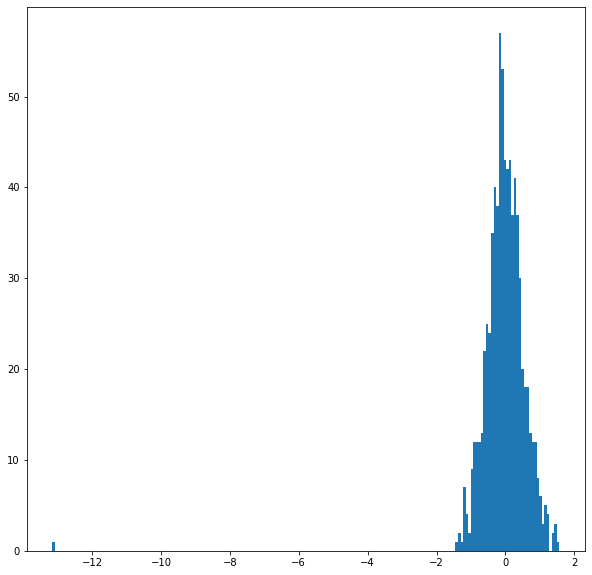

In [11]:
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 5
layer_i = 5
vec = hidden_states[layer_i][batch_i][token_i]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10, 10))
plt.hist(vec, bins=200)
plt.show()

Grouping the values by layer makes sense for the model, but for our purposes we want it grouped by token. 

Current dimensions:

`[# layers, # batches, # tokens, # features]`

Desired dimensions:

`[# tokens, # layers, # features]`

Luckily, PyTorch includes the `permute` function for easily rearranging the dimensions of a tensor. 

However, the first dimension is currently a Python list! 

In [12]:
# `hidden_states` is a Python list.
print('      Type of hidden_states: ', type(hidden_states))

# Each layer in the list is a torch tensor.
print('Tensor shape for each layer: ', hidden_states[0].size())

      Type of hidden_states:  <class 'tuple'>
Tensor shape for each layer:  torch.Size([1, 22, 768])


Let's combine the layers to make this one whole big tensor.

In [13]:
# Concatenate the tensors for all layers. We use `stack` here to create a new dimension in the tensor.
token_embeddings = torch.stack(hidden_states, dim=0)
token_embeddings.size()

torch.Size([13, 1, 22, 768])

Let's get rid of the "batches" dimension since we don't need it.

In [14]:
# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=1)
token_embeddings.size()

torch.Size([13, 22, 768])

Finally, we can switch around the "layers" and "tokens" dimensions with `permute`.

In [15]:
# Swap dimensions 0 and 1.
token_embeddings = token_embeddings.permute(1, 0, 2)
token_embeddings.size()

torch.Size([22, 13, 768])

### 3.3. Creating word and sentence vectors from hidden states

Now, what do we do with these hidden states? We would like to get individual vectors for each of our tokens, or perhaps a single vector representation of the whole sentence, but for each token of our input we have 13 separate vectors each of length 768.

In order to get the individual vectors we will need to combine some of the layer vectors...but which layer or combination of layers provides the best representation? 

Unfortunately, there's no single easy answer... Let's try a couple reasonable approaches, though. Afterwards, I'll point you to some helpful resources which look into this question further.

#### Word Vectors

To give you some examples, let's create word vectors two ways. 

First, let's **concatenate** the last four layers, giving us a single word vector per token. Each vector will have length `4 x 768 = 3,072`. 

In [16]:
# Stores the token vectors, with shape [22 x 3,072]
token_vecs_cat = []

# `token_embeddings` is a [22 x 12 x 768] tensor.
# For each token in the sentence...
for token in token_embeddings:
  # `token` is a [12 x 768] tensor

  # Concatenate the vectors (that is, append them together) from the last four layers.
  # Each layer vector is 768 values, so `cat_vec` is length 3,072.
  cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)

  # Use `cat_vec` to represent `token`.
  token_vecs_cat.append(cat_vec)

print('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

Shape is: 22 x 3072


As an alternative method, let's try creating the word vectors by **summing** together the last four layers.

In [17]:
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:
  # `token` is a [12 x 768] tensor

  # Sum the vectors from the last four layers.
  sum_vec = torch.sum(token[-4:], dim=0)

  # Use `sum_vec` to represent `token`.
  token_vecs_sum.append(sum_vec)

print('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 22 x 768


#### Sentence Vectors

To get a single vector for our entire sentence we have multiple application-dependent strategies, but a simple approach is to average the second to last hiden layer of each token producing a single 768 length vector.

In [18]:
# `hidden_states` has shape [13 x 1 x 22 x 768]

# `token_vecs` is a tensor with shape [22 x 768]
token_vecs = hidden_states[-2][0]

# Calculate the average of all 22 token vectors.
sentence_embedding = torch.mean(token_vecs, dim=0)
print('Our final sentence embedding vector of shape:', sentence_embedding.size())

Our final sentence embedding vector of shape: torch.Size([768])


### 3.4. Confirming contextually dependent vectors

To confirm that the value of these vectors are in fact contextually dependent, let's look at the different instances of the word "bank" in our example sentence:

"After stealing money from the **bank vault**, the **bank robber** was seen fishing on the Mississippi **river bank**."

Let's find the index of those three instances of the word "bank" in the example sentence.

In [19]:
for i, token_str in enumerate(tokenized_text):
  print(i, token_str)

0 [CLS]
1 after
2 stealing
3 money
4 from
5 the
6 bank
7 vault
8 ,
9 the
10 bank
11 robber
12 was
13 seen
14 fishing
15 on
16 the
17 mississippi
18 river
19 bank
20 .
21 [SEP]


They are at 6, 10, and 19.

For this analysis, we'll use the word vectors that we created by summing the last four layers.

We can try printing out their vectors to compare them.

In [20]:
print('First 5 vector values for each instance of "bank".')
print('')
print('bank vault   ', str(token_vecs_sum[6][:5]))
print('bank robber  ', str(token_vecs_sum[10][:5]))
print('river bank   ', str(token_vecs_sum[19][:5]))

First 5 vector values for each instance of "bank".

bank vault    tensor([ 3.3596, -2.9805, -1.5421,  0.7065,  2.0031])
bank robber   tensor([ 2.7359, -2.5577, -1.3094,  0.6797,  1.6633])
river bank    tensor([ 1.5266, -0.8895, -0.5152, -0.9298,  2.8334])


We can see that the values differ, but let's calculate the cosine similarity between the vectors to make a more precise comparison.

In [21]:
from scipy.spatial.distance import cosine

# Calculate the cosine similarity between the word bank 
# in "bank robber" vs "river bank" (different meanings).
diff_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[19])

# Calculate the cosine similarity between the word bank
# in "bank robber" vs "bank vault" (same meaning).
same_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[6])

print('Vector similarity for  *similar*  meanings:  %.2f' % same_bank)
print('Vector similarity for *different* meanings:  %.2f' % diff_bank)

Vector similarity for  *similar*  meanings:  0.94
Vector similarity for *different* meanings:  0.69


This looks pretty good!

### 3.5. Pooling Strategy & Layer Choice

Below are a couple additional resources for exploring this topic.

**BERT Authors**

The BERT authors tested word-embedding strategies by feeding different vector combinations as input features to a BiLSTM used on a named entity recognition task and observing the resulting F1 scores.

(Image from [Jay Allamar](http://jalammar.github.io/illustrated-bert/)'s blog)


![alt text](http://jalammar.github.io/images/bert-feature-extraction-contextualized-embeddings.png)

While concatenation of the last four layers produced the best results on this specific task, many of the other methods come in a close second and in general it is advisable to test different versions for your specific application: results may vary.

This is partially demonstrated by noting that the different layers of BERT encode very different kinds of information, so the appropriate pooling strategy will change depending on the application because different layers encode different kinds of information. 

**Han Xiao's BERT-as-service**

Han Xiao created an open-source project named [bert-as-service](https://github.com/hanxiao/bert-as-service) on GitHub which is intended to create word embeddings for your text using BERT. Han experimented with different approaches to combining these embeddings, and shared some conclusions and rationale on the [FAQ page](https://github.com/hanxiao/bert-as-service#speech_balloon-faq) of the project. 

`bert-as-service`, by default, uses the outputs from the **second-to-last layer** of the model. 

I would summarize Han's perspective by the following:

1. The embeddings start out in the first layer as having no contextual information (i.e., the meaning of the initial 'bank' embedding isn't specific to river bank or financial bank).
2. As the embeddings move deeper into the network, they pick up more and more contextual information with each layer.
3. As you approach the final layer, however, you start picking up information that is specific to BERT's pre-training tasks (the "Masked Language Model" (MLM) and "Next Sentence Prediction" (NSP)). 
    * What we want is embeddings that encode the word meaning well... 
    * BERT is motivated to do this, but it is also motivated to encode anything else that would help it determine what a missing word is (MLM), or whether the second sentence came after the first (NSP). 
4. The second-to-last layer is what Han settled on as a reasonable sweet-spot.

## 4- Appendix

### 4.1. Special tokens

It should be noted that although the `[CLS]` acts as an "aggregate representation" for classification tasks, this is not the best choice for a high quality sentence embedding vector. [According to](https://github.com/google-research/bert/issues/164) BERT author Jacob Devlin: "*I'm not sure what these vectors are, since BERT does not generate meaningful sentence vectors. It seems that this is is doing average pooling over the word tokens to get a sentence vector, but we never suggested that this will generate meaningful sentence representations*."

(However, the [CLS] token does become meaningful if the model has been fine-tuned, where the last hidden layer of this token is used as the "sentence vector" for sequence classification.)


### 4.2. Out of vocabulary words

For **out of vocabulary words** that are composed of multiple sentence and character-level embeddings, there is a further issue of how best to recover this embedding. Averaging the embeddings is the most straightforward solution (one that is relied upon in similar embedding models with subword vocabularies like fasttext), but summation of subword embeddings and simply taking the last token embedding (remember that the vectors are context sensitive) are acceptable alternative strategies.


### 4.3. Similarity metrics

It is worth noting that word-level **similarity comparisons** are not appropriate with BERT embeddings because these embeddings are contextually dependent, meaning that the word vector changes depending on the sentence it appears in. This allows wonderful things like polysemy so that e.g. your representation encodes river "bank" and not a financial institution "bank",  but makes direct word-to-word similarity comparisons less valuable. However, for sentence embeddings similarity comparison is still valid such that one can query, for example, a single sentence against a dataset of other sentences in order to find the most similar. Depending on the similarity metric used, the resulting similarity values will be less informative than the relative ranking of similarity outputs since many similarity metrics make assumptions about the vector space (equally-weighted dimensions, for example) that do not hold for our 768-dimensional vector space.


### 4.4. Implementations

You can use the code in this notebook as the foundation of your own application to extract BERT features from text. However, official [tensorflow](https://github.com/google-research/bert/blob/master/extract_features.py) and well-regarded [pytorch](https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/examples/extract_features.py) implementations already exist that do this for you.  Additionally, [bert-as-a-service](https://github.com/hanxiao/bert-as-service) is an excellent tool designed specifically for running this task with high performance, and is the one I would recommend for production applications. The author has taken great care in the tool's implementation and provides excellent documentation (some of which was used to help create this tutorial) to help users understand the more nuanced details the user faces, like resource management and pooling strategy.

## Cite

Chris McCormick and Nick Ryan. (2019, May 14). *BERT Word Embeddings Tutorial*. Retrieved from http://www.mccormickml.com